In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import joblib

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [3]:
seed = 38
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
train_df = pd.read_csv("mitbih_train.csv", header=None)
test_df = pd.read_csv("mitbih_test.csv", header=None)

X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].astype(int).values

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].astype(int).values

scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  

joblib.dump(scaler, "minmaxscaler.pkl")

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)


In [5]:
class ECGNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ECGNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

model = ECGNet(X_train.shape[1], 5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
train_losses = []
val_losses = []
print("\nEntrenando...\n")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for X_batch_val, y_batch_val in test_loader:
            X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)
            outputs_val = model(X_batch_val)
            val_loss = criterion(outputs_val, y_batch_val)
            val_running_loss += val_loss.item()

    avg_val_loss = val_running_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")


Entrenando...

Epoch 1/200 - Train Loss: 0.4823 - Val Loss: 0.3047
Epoch 2/200 - Train Loss: 0.2415 - Val Loss: 0.2074
Epoch 3/200 - Train Loss: 0.1776 - Val Loss: 0.1711
Epoch 4/200 - Train Loss: 0.1548 - Val Loss: 0.1556
Epoch 5/200 - Train Loss: 0.1383 - Val Loss: 0.1350
Epoch 6/200 - Train Loss: 0.1231 - Val Loss: 0.1324
Epoch 7/200 - Train Loss: 0.1182 - Val Loss: 0.1648
Epoch 8/200 - Train Loss: 0.1146 - Val Loss: 0.1177
Epoch 9/200 - Train Loss: 0.1028 - Val Loss: 0.1126
Epoch 10/200 - Train Loss: 0.0981 - Val Loss: 0.1338
Epoch 11/200 - Train Loss: 0.0957 - Val Loss: 0.1080
Epoch 12/200 - Train Loss: 0.0913 - Val Loss: 0.1045
Epoch 13/200 - Train Loss: 0.0878 - Val Loss: 0.1069
Epoch 14/200 - Train Loss: 0.0846 - Val Loss: 0.1102
Epoch 15/200 - Train Loss: 0.0906 - Val Loss: 0.1260
Epoch 16/200 - Train Loss: 0.0892 - Val Loss: 0.1069
Epoch 17/200 - Train Loss: 0.0799 - Val Loss: 0.1004
Epoch 18/200 - Train Loss: 0.0776 - Val Loss: 0.0960
Epoch 19/200 - Train Loss: 0.0755 - Val

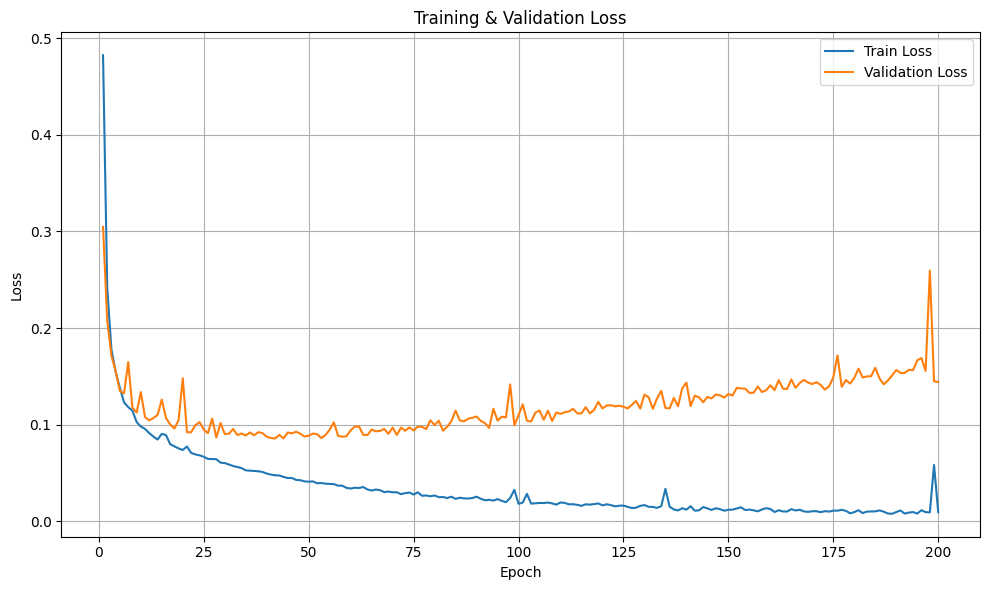

In [6]:
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluando modelo...

Accuracy: 0.9799

Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.86      0.73      0.79       556
           2       0.94      0.94      0.94      1448
           3       0.82      0.74      0.78       162
           4       0.98      0.98      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.92      0.88      0.90     21892
weighted avg       0.98      0.98      0.98     21892



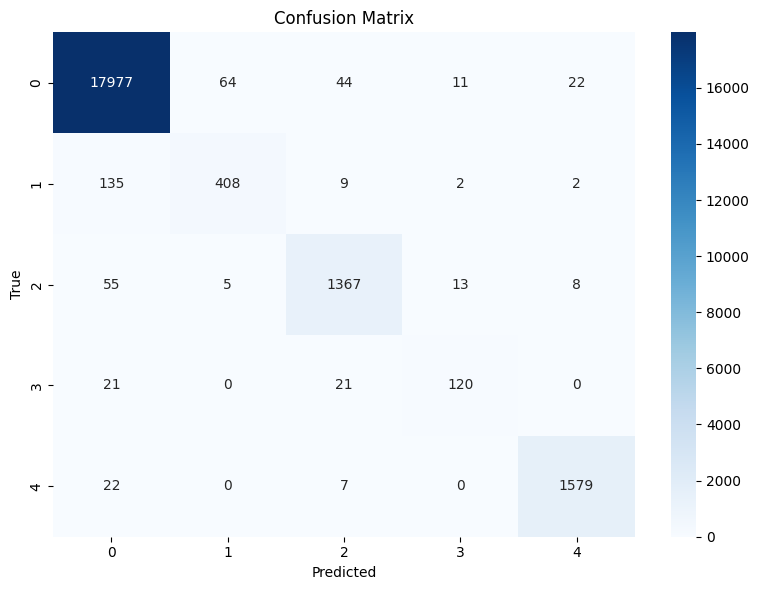


Tiempo de evaluación: 0.13 segundos


In [8]:
print("\nEvaluando modelo...")
model.eval()
y_pred = []
y_true = []

eval_start_time = time.time()

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.numpy())

eval_time = time.time() - eval_start_time
y_pred = np.array(y_pred)
y_true = np.array(y_true)
accuracy = np.mean(y_pred == y_true)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred))

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues",
            xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

print(f"\nTiempo de evaluación: {eval_time:.2f} segundos")

In [9]:
torch.save(model.state_dict(), "ecg_model_mlp.pth")
print("Modelo guardado como 'ecg_model_mlp.pth'")

Modelo guardado como 'ecg_model_mlp.pth'
